# Data Generation

This notebook fully contains all of the steps that were made to generate the data that was used to train the YOLOv8 model. It will be split up into different sections:

1. Processing Functions
2. Data Generation
3. Results

Each section will be met with accompanying notes and details on their executions.

In [1]:
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.patches import Rectangle
from PIL import Image
import cv2
import random
import math
import os
import glob
import re
import pandas as pd

## Processing Functions

This section lists all of the important functions that the data generation process uses to create the data. These involve adding noise to images and splitting data.

In [2]:
def add_gaussian_noise(image, mean, sigma):
    """
    Add Gaussian noise to an image.

    Args:
        image (numpy.ndarray): Input image.
        mean (float): Mean of the Gaussian distribution.
        sigma (float): Standard deviation of the Gaussian distribution.

    Returns:
        numpy.ndarray: Image with added Gaussian noise.
    """
    
    h, w = image.shape
    gaussian_noise = np.random.normal(mean, sigma, (h, w))
    
    # Prevents pixel values from exiting outside of the range
    noisy_image = np.clip(image + gaussian_noise, 0, 255).astype(np.uint8)
    
    return noisy_image

In [3]:
def add_salt_and_pepper_noise(image, salt_prob, pepper_prob):
    """
    Add salt and pepper noise to an image.

    Args:
        image (numpy.ndarray): Input image.
        salt_prob (float): Probability of adding salt noise.
        pepper_prob (float): Probability of adding pepper noise.

    Returns:
        numpy.ndarray: Image with added salt and pepper noise.
    """
    
    noisy_image = np.copy(image)
    
    # Generate random numbers to act as salt and pepper masks
    # If any of the numbers are below the given probabilities, salt/pepper noise will be applied
    salt_mask = np.random.rand(*image.shape) < salt_prob
    pepper_mask = np.random.rand(*image.shape) < pepper_prob

    # Apply salt noise (set pixels to maximum value)
    noisy_image[salt_mask] = 255

    # Apply pepper noise (set pixels to minimum value)
    noisy_image[pepper_mask] = 0

    return noisy_image


In [4]:
def split_data(n):
    """
    Given an argument n, this function splits the data into training, validation
    and testing splits using a 60, 30, 10 split.
    
    Priorities the training split -> validation split -> testing split in cases
    where n is small. Used for splitting individual characters up.

    Args:
        n (int): The amount of data. n has to be at least 2.

    Returns:
        tuple: 3-tuple containing the character numbers for the train, valid, test splits
    """
    assert n >= 2, "n must be at least 2"
    
    # Training and validation need at least one data point
    training_size = max(1, int(0.6 * n))
    validation_size = max(1, int(0.3 * n))
    
    # Create the three splits
    training_numbers = range(1, training_size + 1)
    validation_numbers = range(training_size + 1, training_size + validation_size + 1)
    testing_numbers = range(training_size + validation_size + 1, int(n + 1))
    
    return training_numbers, validation_numbers, testing_numbers

## Data Generation

This section will go over the main function that is used to generate the data. The process is as follows:

1. Split the individual characters into trainining, validation and testing sets.
2. Create a randomly sized grid and place the characters in their cells on a blank image
3. Retrieve the bounding box parameters for each character
4. Overlay the grid onto a random background image
5. Apply augmentations from a set of given transformations
6. Save the images along with their bounding box parameters (Optional)
7. Display the images with their bounding boxes (Optional)

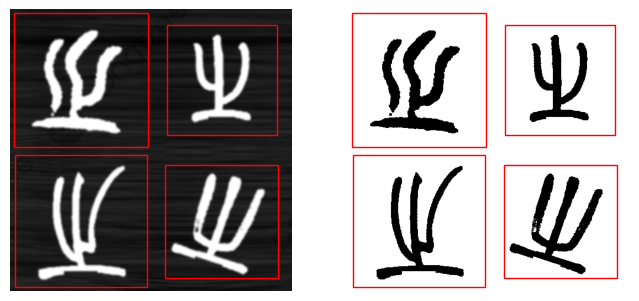

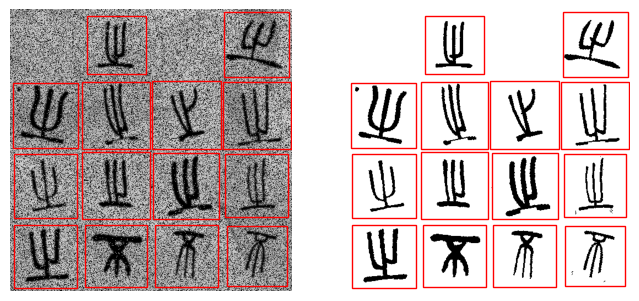

In [5]:
def generate_images(save=False, display=0, num_images=1200):
    """
    Main function used to generate data for YOLOv8 model to train on.

    Args:
        save (boolean): Save the images and their bounding box parameters in the format required for YOLOv8 training.
        display (int): The number of images to display during data generation.
        num_images (int): The number of images to generate
    """
    
    # Initialising variables:
        # ptr (list): Pointer to next image for (train, valid, test) splits.
        # mode (int): Mode 0, 1, 2 corresponds to data being generated for train, valid, test respectively
        # bg (list): Pointer to next background image for (train, valid, test) splits.
        # image_num (int): Counter for the number of images generated
    ptr = [-1,-1,-1]
    mode = 0
    bg = [-1,-1,-1]
    image_num = 1
    
    if display > num_images:
        display = 0
        
    # Counting the occurences of each of the 1000 characters in the dataset
    character_path = './final-dataset' # Change the file path to where the characters are stored
    characters = glob.glob(f'{character_path}/**/*.png', recursive=True)
    occurences = np.zeros(1000)
    for character in characters:
        # RegEx to match on the number found before an underscore
        # This is the variant number
        match = int(re.findall(r'\d*(?=_)', character)[0])
        occurences[match - 1] += 1
        
    # Step 1: Splitting up the individual characters into (train, valid, test) splits
        # Using the occurence array, the function defined previously can easily
        # split the characters into a 60, 30, 10 split where n = occurence of the character
    character_images = [[], [], []]
    for i, occurence in enumerate(occurences):
        train_set, valid_set, test_set = split_data(occurence)
        # Retrieving the file paths for each character
        # and adding them to their respective splits
        for j in train_set:
            character_images[0].append(f'{character_path}/{i+1}/{i+1}_{j}.png')
        for j in valid_set:
            character_images[1].append(f'{character_path}/{i+1}/{i+1}_{j}.png')
        for j in test_set:
            character_images[2].append(f'{character_path}/{i+1}/{i+1}_{j}.png')
    
    # This is the start of the data generation process. Creates one image at a time
    while image_num <= num_images:
        
        # Setting the mode based on how many images have been generated so far
        if image_num <= num_images * 0.7:
            mode = 0
        elif image_num <= num_images * 0.9:
            mode = 1
        else:
            mode = 2
            
        # Creating a blank image
        canvas = np.ones((512,512)).astype('uint8')
        n,m = canvas.shape

        # Step 2: Creating a randomly sized grid for the characters
        size = random.randint(2,16)
        
        # List to store the bounding box parameters of each character in the image
        bboxes = []
        
        # Looping through each of the grid cells
        for i in range(size):
            for j in range(size):
                
                # With probability 0.2, the character is skipped
                chance = random.random()
                if chance < 0.2:
                    continue
                
                # Opening the image file pointed at by ptr and thresholding it using Otsu threshold
                ptr[mode] = (ptr[mode] + 1) % len(character_images[mode])
                im = np.asarray(Image.open(character_images[mode][ptr[mode]]).convert('L'))
                _, im = cv2.threshold(im, 0, 1, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
                
                # Performing random resize and rotation to the character
                scale = random.uniform(0.75, 1.0)
                im = cv2.resize(im, (int(n / size * scale), int(m / size * scale)))
                angle = np.random.normal(0, 10)
                rotation_matrix = cv2.getRotationMatrix2D((im.shape[0] / 2, im.shape[1] / 2), angle, 1)
                im = cv2.warpAffine(im, rotation_matrix, (im.shape[0], im.shape[1]), borderValue=(1))
                
                # Step 3: Computing the centre of character image and its array bounding box parameters
                centre = (int((n // size) * (i + 0.5)), int((n // size) * (j + 0.5)))
                min_x = centre[0] - math.floor(im.shape[0] / 2)
                max_x = centre[0] + math.ceil(im.shape[0] / 2)
                min_y = centre[1] - math.floor(im.shape[1] / 2)
                max_y = centre[1] + math.ceil(im.shape[1] / 2)

                # Placing the characters into their respective locations in the blank image
                # with respect to the coordinates of the cells of the grid
                canvas[min_x : max_x, min_y : max_y] = im
                bboxes.append((min_x, min_y, im.shape[0], im.shape[1]))
                
        # Step 4: Opening the background image file pointed at by bg
        if mode == 0:
            bg[mode] = (bg[mode] % 25) + 1
            bg_im = Image.open('./backgrounds/train-backgrounds/bg_' + str(bg[mode]) + '.jpeg')
        elif mode == 1:
            bg[mode] = (bg[mode] % 11) + 1
            bg_im = Image.open('./backgrounds/valid-backgrounds/bg_' + str(bg[mode]) + '.jpeg')
        else:
            bg[mode] = (bg[mode] % 7) + 1
            bg_im = Image.open('./backgrounds/test-backgrounds/bg_' + str(bg[mode]) + '.jpeg')

        # Taking a random 512x512 block from the background image to act as the background
        bg_im = np.asarray(bg_im.convert('L'))
        height, width = bg_im.shape
        # Ensures that the background is at least 512x512 by resizing
        if height < 512 or width < 512:
            bg_im = cv2.resize(bg_im, (2000,2000))
            height, width = bg_im.shape
        top_left_x = np.random.randint(0, height - 512 + 1)
        top_left_y = np.random.randint(0, width - 512 + 1)
        random_block = bg_im[top_left_x:top_left_x + 512, top_left_y:top_left_y + 512]
        
        # Overlays the binary canvas containing the characters onto the background image
        overlay = np.copy(random_block)
        overlay[canvas == 0] = 0
        
        # Depending on the size of the grid, a different kernel size is used for Gaussian blur
        if size == 2:
            kernel_size = (9,9)
        elif size == 3:
            kernel_size = (7,7)
        elif size == 4:
            kernel_size = (5,5)
        else:
            kernel_size = (3,3)
            
        blurred_image = cv2.GaussianBlur(overlay, kernel_size, 0)
        
        # Step 5: A random selection of augmentations are used
        
        # This transformation inverts the image colour
        blurred_image = random.choice([blurred_image, 255 - blurred_image])
        
        # Parameters are randomly initialised for use in the functions previously defined
        mean = random.uniform(0, 100)
        sigma = random.uniform(0, 100)
        salt_prob = random.uniform(0, 0.25)
        pepper_prob = random.uniform(0, 0.25)
        
        # An augmented image is randomly chosen with p = 0.5 for the regular image,
        # p = 0.25 for an image with Gaussian blur and p = 0.25 for salt and pepper
        images = [blurred_image, 
                  blurred_image,
                  add_gaussian_noise(blurred_image, mean, sigma), 
                  add_salt_and_pepper_noise(blurred_image, salt_prob, pepper_prob)]
        final_im = random.choice(images)
        final_im = Image.fromarray(final_im)
            
        # Step 6: Saving the image and translating the bounding box parameters (Optional)
        if save:
            
            rows, cols = final_im.shape
            image_name = str(image_num) + '.png'
            
            if mode == 0:
                dir_name = 'train'
            elif mode == 1:
                dir_name = 'valid'
            else:
                dir_name = 'test'
                
            # A YOLOv8 dataset directory needs to have train, valid, test directories with images, labels
            # sub-directories and a data.yaml file. More details can be found in the source files.
            dataset_dir = './yolov8-data' # Change to where you want to store the generated data
            final_im.save(f'{dataset_dir}/{dir_name}/images/{image_name}')
            file = open(f'{dataset_dir}/{dir_name}/labels/{image_num}.txt', 'a')
            
            # The bounding box parameters required for YOLOv8 are of normalised (x,y,w,h) format
            for i,(min_y, min_x, height, width) in enumerate(bboxes):
                if i == 0:
                    file.write(f'0 {(min_x + width / 2) / cols} {(min_y + height / 2) / rows} {width / cols} {height / rows}')
                else:
                    file.write(f'\n0 {(min_x + width / 2) / cols} {(min_y + height / 2) / rows} {width / cols} {height / rows}')
        
        image_num += 1
        
        # Step 7: Display the generated images (Optional)
        if image_num - 1 <= display:
            plt.figure(figsize=(8,8))
            plt.subplot(1,2,1)
            plt.imshow(final_im,cmap='gray')
            plt.axis('off')
            ax = plt.gca()

            for (min_x, min_y, width, height) in bboxes:
                    rect = Rectangle((min_y, min_x),width,height,linewidth=1,edgecolor='r',facecolor='none')
                    ax.add_patch(rect)
            plt.subplot(1,2,2)
            plt.imshow(canvas,cmap='gray')
            plt.axis('off')
            ax = plt.gca()

            for (min_x, min_y, width, height) in bboxes:
                    rect = Rectangle((min_y, min_x),width,height,linewidth=1,edgecolor='r',facecolor='none')
                    ax.add_patch(rect)
            plt.show()
        

generate_images(display=2, num_images=15)


## Results

Here are some results from the data generation process. The first cell below displays the background images that were used for creating the data in a mosaic format.

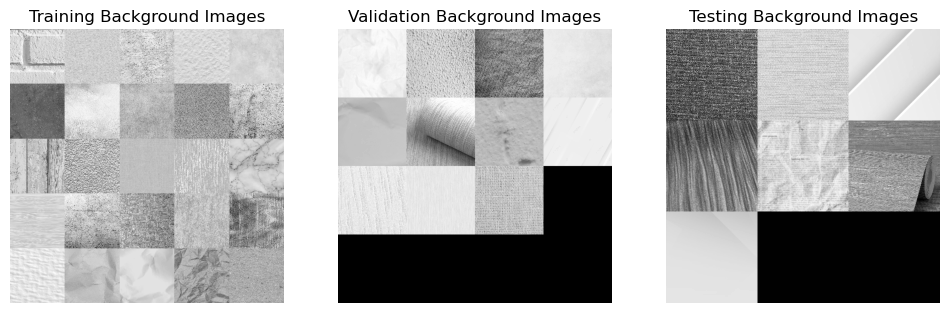

In [6]:
training_backgrounds = np.ones((5 * 512, 5 * 512))
validation_backgrounds = np.ones((4 * 512, 4 * 512))
testing_backgrounds = np.ones((3 * 512, 3 * 512))

training_bgs = glob.glob('./backgrounds/train-backgrounds/*')
validation_bgs = glob.glob('./backgrounds/valid-backgrounds/*')
testing_bgs = glob.glob('./backgrounds/test-backgrounds/*')

for i, bg_path in enumerate(training_bgs):
    min_x = (i // 5) * 512
    min_y = (i % 5) * 512
    bg_im = np.asarray(Image.open(bg_path).convert('L'))
    top_left_x = np.random.randint(0, bg_im.shape[0] - 512 + 1)
    top_left_y = np.random.randint(0, bg_im.shape[1] - 512 + 1)
    random_block = bg_im[top_left_x:top_left_x + 512, top_left_y:top_left_y + 512]
    training_backgrounds[min_x : min_x + 512, min_y : min_y + 512] = random_block

for i, bg_path in enumerate(validation_bgs):
    min_x = (i // 4) * 512
    min_y = (i % 4) * 512
    bg_im = np.asarray(Image.open(bg_path).convert('L'))
    top_left_x = np.random.randint(0, bg_im.shape[0] - 512 + 1)
    top_left_y = np.random.randint(0, bg_im.shape[1] - 512 + 1)
    random_block = bg_im[top_left_x:top_left_x + 512, top_left_y:top_left_y + 512]
    validation_backgrounds[min_x : min_x + 512, min_y : min_y + 512] = random_block
    
for i, bg_path in enumerate(testing_bgs):
    min_x = (i // 3) * 512
    min_y = (i % 3) * 512
    bg_im = np.asarray(Image.open(bg_path).convert('L'))
    top_left_x = np.random.randint(0, bg_im.shape[0] - 512 + 1)
    top_left_y = np.random.randint(0, bg_im.shape[1] - 512 + 1)
    random_block = bg_im[top_left_x:top_left_x + 512, top_left_y:top_left_y + 512]
    testing_backgrounds[min_x : min_x + 512, min_y : min_y + 512] = random_block
    
training_backgrounds = cv2.resize(training_backgrounds, (512,512))
validation_backgrounds = cv2.resize(validation_backgrounds, (512,512))
testing_backgrounds = cv2.resize(testing_backgrounds, (512,512))

fig, axes = plt.subplots(1, 3, figsize=(12,12))

axes[0].imshow(training_backgrounds, cmap='gray')
axes[0].axis('off')
axes[0].set_title('Training Background Images')

axes[1].imshow(validation_backgrounds, cmap='gray')
axes[1].axis('off')
axes[1].set_title('Validation Background Images')

axes[2].imshow(testing_backgrounds, cmap='gray')
axes[2].axis('off')
axes[2].set_title('Testing Background Images')

plt.show()

The images shown below are a random selection of the training images that were generated. If you wish to run this cell, make sure that the file path is correct.

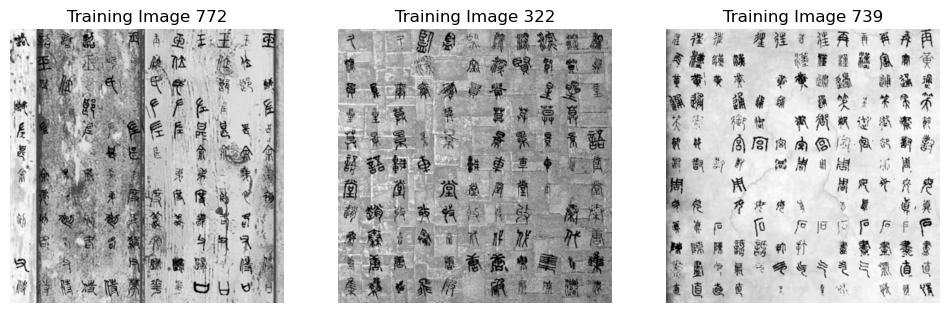

In [7]:
training_images = glob.glob('./yolov8-data/train/images/*')
random_image = (random.randint(0,len(training_images) - 1), random.randint(0,len(training_images) - 1), random.randint(0,len(training_images) - 1))

fig, axes = plt.subplots(1, 3, figsize=(12,12))

axes[0].imshow(np.asarray(Image.open(training_images[random_image[0]]).convert('L')), cmap='gray')
axes[0].axis('off')
axes[0].set_title(f'Training Image {random_image[0] + 1}')

axes[1].imshow(np.asarray(Image.open(training_images[random_image[1]]).convert('L')), cmap='gray')
axes[1].axis('off')
axes[1].set_title(f'Training Image {random_image[1] + 1}')

axes[2].imshow(np.asarray(Image.open(training_images[random_image[2]]).convert('L')), cmap='gray')
axes[2].axis('off')
axes[2].set_title(f'Training Image {random_image[2] + 1}')
plt.show()

Finally, these are plotting the graphs that were obtained from performing the confidence threshold investigation with the trained model on real world data.

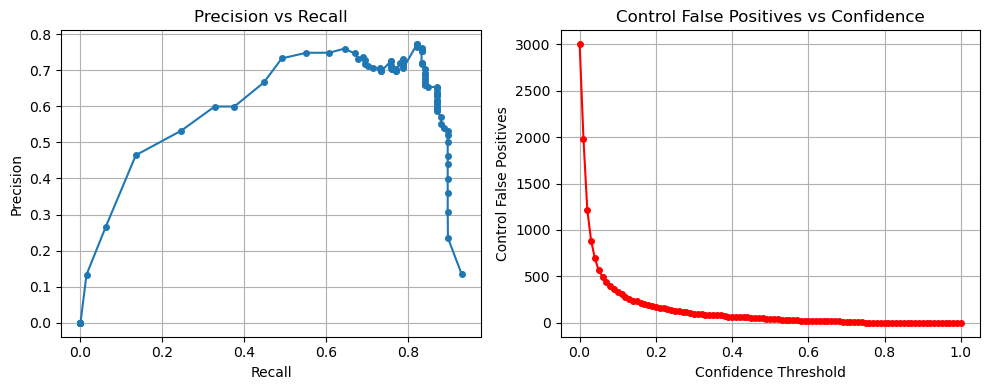

In [8]:
file_path = './hyper-parameter-testing/results.csv'
data = pd.read_csv(file_path)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

ax1.plot(data['recall'], data['precision'], marker='o', markersize=4)
ax1.set_title('Precision vs Recall')
ax1.set_xlabel('Recall')
ax1.set_ylabel('Precision')
ax1.grid(True)

ax2.plot(data['confidence'], data['control_fp'], marker='o', markersize=4, color='red')
ax2.set_title('Control False Positives vs Confidence')
ax2.set_xlabel('Confidence Threshold')
ax2.set_ylabel('Control False Positives')
ax2.grid(True)

plt.tight_layout()
plt.show()